We will try to derive and verify here the Kelly criteria

We have two assets 

    - a risk free asset such as cash which we can invest and earn interest r

    - A risky asset available such as index/stock whose returns are log normally distributed. (parameters $\mu$, $\sigma$)



Let us assume we have wealth $X$ and we decide to invest a fraction $f$ in stock/index. And rest we invest in bond/cash.

Change in stock/index in time $t$ to $d + dt$ is  $=\mu Xf dt + \sigma Xf \tilde{dB}$

Above comes from log normal assumption - where stochastic process varies as $dS = \mu S dt + \sigma S \tilde{dB}$
where $\tilde{dB}$ is Brownian shock

Change in cash deposit $= (X-Xf)r*dt $

Therefore total change in wealth in $t$ to $d + dt$ is = $\mu Xf dt + \sigma Xf \tilde{dB} + (X-Xf)r*dt $ 


$dX = \mu Xf dt + \sigma Xf \tilde{dB} + (X-Xf)r*dt $ 

This can be simplified as :

$dX =  ( r + f(\mu - r)) X dt + (\sigma f) X \tilde{dB} $ 

Degine $\mu\prime = ( r + f(\mu - r)) $ and $\sigma\prime = (\sigma f)$ then above becomes

$dX =  \mu\prime  X dt + \sigma\prime X \tilde{dB} $ 

Solution of above stochastic differential Equation is given by 

$\frac{X}{X_0} = e^{ (\mu\prime - 0.5*\sigma\prime^2) + \sigma\prime \tilde{B(t)} }$

Therefore 

$log(\frac{X}{X_0}) = (\mu\prime - 0.5*\sigma\prime^2) * t +\sigma\prime \tilde{B(t)} $

$\implies$

$E[log(\frac{X}{X_0})] = (\mu\prime - 0.5*\sigma\prime^2) * t +\sigma\prime E[\tilde{B(t)}] =  (\mu\prime - 0.5*\sigma\prime^2) * t $

Average Expected Growth:
$G = (1/t) E[log(\frac{X}{X_0})] = (\mu\prime - 0.5*\sigma\prime^2) =  (\mu\prime - 0.5*\sigma\prime^2) * t = ( r + f(\mu - r)) - (1/2) \sigma^2 * f^2$

For Optimal f, 

$\frac{\partial G}{\partial f} = \mu - r - f\sigma^2 = 0$

=> 

$ f = \frac{\mu - r}{\sigma ^2}$

We know it is maxima as second derivation again is negative (= $-\sigma^2$)

Below we try to get using S&P data. I see the fraction is > 1. Seems a leverage is the way to go.

In [1]:
## Download S&P Index data
## I am taking my own codes from https://github.com/jaivrat/xcs229ii-project/blob/main/stonk_trader/multi_asset/data_prep_and_preprocess.ipynb

import time
from datetime import datetime
import pandas as pd
import numpy as np
import itertools
from datetime import timedelta
from stockstats import StockDataFrame as Sdf
import math

## Download historical data
import time
from datetime import datetime

def ticker_downloader(p_start_date_str, p_end_date_str, p_ticker, p_interval = '1d'):
    # Add timestamp
    st = p_start_date_str + " " + "23:59"
    end = p_end_date_str + " " + "23:59"
    # Reconvert to timestamp
    st = datetime.strptime(st, "%Y.%m.%d %H:%M")
    end = datetime.strptime(end, "%Y.%m.%d %H:%M")
    # Get back system time format for final query
    period1 = int(time.mktime(st.timetuple()))
    period2 = int(time.mktime(end.timetuple()))
    query_string=f"https://query1.finance.yahoo.com/v7/finance/download/{p_ticker}?period1={period1}&period2={period2}&interval={p_interval}&events=history&includeAdjustedClose=true"
    result_df = None
    try:
        result_df = pd.read_csv(query_string)
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print(f"ticker_downloader: For ticker={p_ticker}, start={p_start_date_str}, end={p_end_date_str}: {e}")
        return None
    return result_df

# Test using TSLA
# ticker_downloader("2020.12.01", "2020.12.31", "TSLA")

def download_all_tickers(p_start_date_str, p_end_date_str, p_tickers_list, sleep=True):
    # make sure in correct input format
    p_start_date_str = datetime.strptime(p_start_date_str,"%Y.%m.%d").strftime("%Y.%m.%d")
    p_end_date_str = datetime.strptime(p_end_date_str  ,"%Y.%m.%d").strftime("%Y.%m.%d")
    
    data_dict = {}
    for ticker in p_tickers_list:
        # Not sure if Yahoo blocks me for very fast request, lets sleep for random 0-5 seconds
        if sleep:
            if ticker != p_tickers_list[0]:
                time.sleep(np.random.randint(low = 0, high = 5, size = 1)[0])
        print(f"Downloading {ticker}..")
        data_dict[ticker] = ticker_downloader(p_start_date_str, p_end_date_str, ticker, '1d')
        # add ticker information if it is found
        if data_dict[ticker] is not None:
            data_dict[ticker]["tic"] = ticker
    print("Download finished! Organising records now..")
    # join whole universe with this data
    all_data = pd.concat([v for k,v in data_dict.items()])
    del data_dict
    # Some data may be missing - let us create a union of them all
    all_data["Date"] = [ datetime.strptime(dt,"%Y-%m-%d").date() for dt in all_data.Date.values]
    all_data = pd.DataFrame(list(itertools.product(all_data["Date"].unique(),all_data["tic"].unique())))\
                    .rename(columns={0:"Date", 1:"tic"})\
                    .merge(all_data, how='left',  left_on=["Date", "tic"], right_on=["Date", "tic"])\
                    .sort_values(by=["Date", "tic"])
    print("Done!")
    return all_data

# Adjusts all intraday prices by adj factor derived from "Adj Close" and Close
def adjust_prices(p_data_df):
    ## Some preprocessing here  Adj Close = Close * adj_factor
    ## Similarly we can adjust all related prices Open	High	Low	Close
    adj_factor = p_data_df["Adj Close"]/p_data_df["Close"]
    all_data_adj = p_data_df.copy()
    for colname in ["Open","High","Low","Close"]:
        all_data_adj[colname]  = all_data_adj[colname] * adj_factor
        all_data_adj = all_data_adj.rename(columns = {colname: colname.lower()})
    all_data_adj.drop(columns = ["Adj Close"], inplace = True)
    all_data_adj = all_data_adj.rename(columns = {"Volume": "volume"})
    return all_data_adj

### Add returns to the data
def add_returns(p_data_df, p_price_column_name):
    returns = p_data_df.groupby(["tic"])\
                .apply( lambda df: df.set_index("Date")[[p_price_column_name]]\
                                     .pct_change()\
                                     .reset_index())\
                .reset_index()\
                .drop(columns=["level_1"])\
                .sort_values(by=["Date", "tic"])\
                .rename(columns = {p_price_column_name : "returns" + "_"+ p_price_column_name })

    res = p_data_df.merge(returns, how='left',  left_on=["Date", "tic"], right_on=["Date", "tic"])
    return res


In [2]:
## TEST
test_tickers = ["SPY"]
all_data = download_all_tickers("1990.01.01", "2022.06.18", test_tickers, sleep = True)
all_data_adj = adjust_prices(p_data_df = all_data)

Download finished! Organising records now..
Done!


In [3]:
all_data_adj

,Date,tic,open,high,low,close,volume
0,1993-01-29,SPY,25.456184,25.456184,25.329536,25.438091,1003200
1,1993-02-01,SPY,25.456187,25.619020,25.456187,25.619020,480500
2,1993-02-02,SPY,25.600920,25.691383,25.546642,25.673290,201300
3,1993-02-03,SPY,25.709482,25.962778,25.691390,25.944685,529400
4,1993-02-04,SPY,26.035143,26.107514,25.745663,26.053236,531500
...,...,...,...,...,...,...,...
7396,2022-06-13,SPY,378.216231,380.167792,371.694385,373.387085,170004900
7397,2022-06-14,SPY,375.229126,376.314433,368.996041,372.261932,104011800
7398,2022-06-15,SPY,375.736918,382.248798,370.519466,377.569031,125666800
7399,2022-06-16,SPY,368.916412,369.344554,362.514045,365.072998,134473300


In [4]:
all_data_adj["close_shift"]= all_data_adj.close.shift(1)
all_data_adj["daily_ret"] = (all_data_adj.close/all_data_adj["close_shift"])-1.0
all_data_adj

,Date,tic,open,high,low,close,volume,close_shift,daily_ret
0,1993-01-29,SPY,25.456184,25.456184,25.329536,25.438091,1003200,NaN,NaN
1,1993-02-01,SPY,25.456187,25.619020,25.456187,25.619020,480500,25.438091,0.007113
2,1993-02-02,SPY,25.600920,25.691383,25.546642,25.673290,201300,25.619020,0.002118
3,1993-02-03,SPY,25.709482,25.962778,25.691390,25.944685,529400,25.673290,0.010571
4,1993-02-04,SPY,26.035143,26.107514,25.745663,26.053236,531500,25.944685,0.004184
...,...,...,...,...,...,...,...,...,...
7396,2022-06-13,SPY,378.216231,380.167792,371.694385,373.387085,170004900,388.123413,-0.037968
7397,2022-06-14,SPY,375.229126,376.314433,368.996041,372.261932,104011800,373.387085,-0.003013
7398,2022-06-15,SPY,375.736918,382.248798,370.519466,377.569031,125666800,372.261932,0.014256
7399,2022-06-16,SPY,368.916412,369.344554,362.514045,365.072998,134473300,377.569031,-0.033096


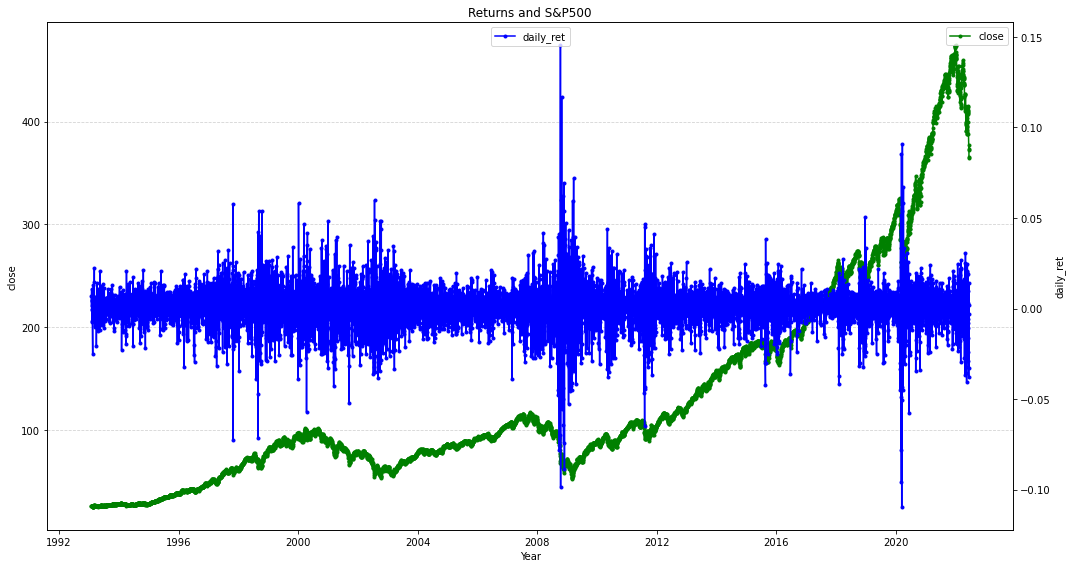

In [5]:
import matplotlib.pyplot as plt

# all_data_adj.close.plot()

fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()
ax.set_title('Returns and S&P500')
ax.set_xlabel('Year')
ax.plot(all_data_adj['Date'], all_data_adj['close'], color='green', marker='.')
ax2.plot(all_data_adj['Date'], all_data_adj['daily_ret'], color='blue', marker='.')
ax.set_ylabel('close')
ax2.set_ylabel('daily_ret')
ax.legend(['close'])
ax2.legend(['daily_ret'], loc='upper center')
# ax.set_xticks(pd.DatetimeIndex(p_turb_sp['Date']).date)
# ax.set_xticklabels(pd.DatetimeIndex(p_turb_sp['Date']).year, rotation=90)
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()
    

In [6]:
all_data_adj[["daily_ret"]].dropna()

,daily_ret
1,0.007113
2,0.002118
3,0.010571
4,0.004184
5,-0.000694
...,...
7396,-0.037968
7397,-0.003013
7398,0.014256
7399,-0.033096


In [7]:
returns = all_data_adj[["daily_ret"]].dropna().daily_ret.values

log_returns = [math.log(1.0 + r) for r in returns]
log_returns
u_bar = np.mean(log_returns)
sd    = np.std(log_returns, ddof = 1)
print(f'u_bar = {u_bar} sd={sd}')


u_bar = 0.0003602706769210419 sd=0.0118782761796034


In [8]:
mu  = u_bar + 0.5 * sd * sd
sigma  = sd
print(f'mu = {mu} sigma={sigma}')

mu = 0.00043081739942050866 sigma=0.0118782761796034


In [9]:
r = (1.56743/100)/252
sharpe= (mu  - r)/sigma
kelly_fraction = sharpe/sigma
print(f'kelly_fraction = {kelly_fraction}')  

kelly_fraction = 2.612579175798647
